In [1]:
!python -V

Python 3.8.10


# Load Packages

In [2]:
import pickle
import warnings
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
warnings.filterwarnings("ignore")

# Data Ingestion

In [4]:
df = pd.read_parquet("data/green_tripdata_2022-01.parquet")

In [5]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.50,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.50,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.50,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.00,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.00,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62490,2,2022-01-31 23:25:00,2022-01-31 23:33:00,None,NaN,40,65,NaN,1.40,8.38,0.00,0.0,1.93,0.0,None,0.3,10.61,NaN,NaN,NaN
62491,2,2022-01-31 23:52:00,2022-02-01 00:10:00,None,NaN,36,61,NaN,2.97,14.92,0.00,0.0,0.00,0.0,None,0.3,15.22,NaN,NaN,NaN
62492,2,2022-01-31 23:17:00,2022-01-31 23:36:00,None,NaN,75,167,NaN,3.70,16.26,0.00,0.0,0.00,0.0,None,0.3,16.56,NaN,NaN,NaN
62493,2,2022-01-31 23:45:00,2022-01-31 23:55:00,None,NaN,116,166,NaN,1.88,9.48,0.00,0.0,2.17,0.0,None,0.3,11.95,NaN,NaN,NaN


To better understand each individual columns (or potentially features for modelling), we will refer to the official [data dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).

In [6]:
# check all columns
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [7]:
# check the dtypes
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [8]:
# generate `duration` column – as a target
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

# converting `duration` to minutes
df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)

In [9]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.50,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.50,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.50,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.00,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.00,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62490,2,2022-01-31 23:25:00,2022-01-31 23:33:00,None,NaN,40,65,NaN,1.40,8.38,...,0.0,1.93,0.0,None,0.3,10.61,NaN,NaN,NaN,8.000000
62491,2,2022-01-31 23:52:00,2022-02-01 00:10:00,None,NaN,36,61,NaN,2.97,14.92,...,0.0,0.00,0.0,None,0.3,15.22,NaN,NaN,NaN,18.000000
62492,2,2022-01-31 23:17:00,2022-01-31 23:36:00,None,NaN,75,167,NaN,3.70,16.26,...,0.0,0.00,0.0,None,0.3,16.56,NaN,NaN,NaN,19.000000
62493,2,2022-01-31 23:45:00,2022-01-31 23:55:00,None,NaN,116,166,NaN,1.88,9.48,...,0.0,2.17,0.0,None,0.3,11.95,NaN,NaN,NaN,10.000000


In [10]:
# understanding the trip duration
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    62495.000000
mean        19.019387
std         78.215732
min          0.000000
50%         11.583333
95%         35.438333
98%         49.722667
99%         68.453000
max       1439.466667
Name: duration, dtype: float64

In [11]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [12]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance", ]

In [13]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [14]:
df[categorical] = df[categorical].astype(str)

In [15]:
df[numerical].dtypes

trip_distance    float64
dtype: object

# Feature Engineering

In [16]:
# example usage of DictVectorizer
train_dicts = df[categorical + numerical].to_dict(orient="records")

In [17]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [18]:
X_train

<59603x471 sparse matrix of type '<class 'numpy.float64'>'
	with 178809 stored elements in Compressed Sparse Row format>

In [19]:
dv.feature_names_[:10]

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=11',
 'DOLocationID=111']

In [20]:
target = "duration"
y_train = df[target].values

In [21]:
y_train

array([ 1.2       ,  8.71666667, 16.2       , ..., 19.        ,
       10.        , 34.        ])

# Model Training

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lr.predict(X_train)

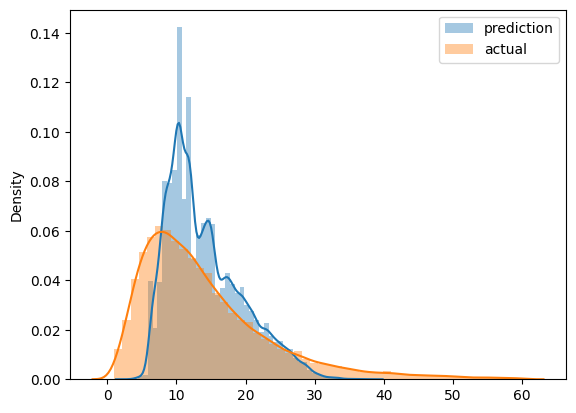

In [24]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [25]:
mean_squared_error(y_train, y_pred, squared=False)

7.735793552152567

# Code Refactoring

In [26]:
def read_dataframe(filename: str) -> pd.DataFrame:
    df = pd.read_parquet(filename)
    
    # generate `duration` column – as a target
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    # converting `duration` to minutes
    df["duration"] = df["duration"].apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [27]:
df_train = read_dataframe("data/green_tripdata_2022-01.parquet")
df_val = read_dataframe("data/green_tripdata_2022-02.parquet")

In [28]:
len(df_train), len(df_val)

(59603, 66097)

In [29]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance", ]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [30]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.193832544103035

In [34]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [32]:
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.281268257779285

In [35]:
with open("models/lasso_reg.bin", "wb") as f_out:
    pickle.dump((dv, lasso), f_out)

In [33]:
ridge = Ridge(alpha=0.05)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.193852158251287

In [36]:
with open("models/ridge.bin", "wb") as f_out:
    pickle.dump((dv, ridge), f_out)